##Step 1: You may select 1) any dataset from the machine learning repository - https://archive.ics.uci.edu/ml/index.php, 2) any dataset from Kaggle - https://www.kaggle.com/datasets, or 3) any dataset openly provided by an organization, preferably non-profit, that could benefit from this analysis. Your selection must be based on the following characteristics [Note: on Kaggle – many of the datasets provide links to the original dataset such that you do not have to set up a new Kaggle profile. Kaggle was acquired by Google in 2017]
1. Must have a sample size of at least 500 observations
2. Must have at least two variables belonging to a legally recognized protected class
3. Must have at least two dependent variables (outcome variables) that could result in favorable or unfavorable outcomes [Note: Use your subjective opinion based on the discussions we’ve had in class]
4. Must be related to one of the regulated domains: Credit, Education, Employment, or Housing and ‘Public Accommodation’ [Note: Loosely, any dataset that could have potential bias in outcomes based on 2 protected class membership is acceptable. Also, don’t be biased by how the dataset is labeled/organized –you can think creatively about how to structure the dataset so it’s compliant to the requirements]

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#install AI Fairness 360 toolkit
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 kB 5.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# Read in the dataset
df = pd.read_csv("survey.csv")


Mounted at /content/drive


pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


##Step 2:
1) Identify the members associated with your protected class variables and group together into a subset of membership categories as appropriate
2) Discretize the values associated with your dependent variables into discrete categories/numerical values as appropriate
3) Compute the frequency of each membership category associated with each of your protected class variables from Step 2.1
4) Create a histogram for each protected class variable that graphs the frequency values of its membership categories as a function of the dependent variables

In [3]:
# Clean Gender field 0 = Unknown, 1 = Male, 2 = Female, 3 = Others
# Make Fields lowercase 
df['Gender'] = df['Gender'].str.lower().str.strip()

male_set = ['male', 'm', 'mail', 'make', 'mal', 'man', 'cis male', 'cis man', 'male (cis)', 'malr', 'maile', 
            'male-ish', 'msle', 1, 'something kinda male?']
female_set = ['female', 'woman', 'cis female', 'cis-female/femme', 'f', 'femail', 'femake', 'female (cis)', 2]
non_binary = ['female (trans)', 'fluid', 'genderqueer', 'guy (-ish) ^_^', 'male leaning androgynous', 'non-binary', 
             'queer', 'queer/she/they', 3, 'trans woman', 'trans-female']
NA = ['a little about you', 'agender', 'all','androgyne', 'enby', 'nah', 'neuter', 'ostensibly male, unsure what that really means',
     'p', 0, 'NaN']

# print(any(filter(lambda x: x in male_set, ds['Gender'])))
df.loc[df['Gender'].isin(male_set), 'Gender'] = 1
df.loc[df['Gender'].isin(female_set), 'Gender'] = 2
df.loc[df['Gender'].isin(non_binary), 'Gender'] = 3
df.loc[df['Gender'].isin(NA), 'Gender'] = 0
df.loc[df['Gender'].isna(), 'Gender'] = 0
df.groupby('Gender').count()

,Timestamp,Age,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
Gender,,,,,,,,,,,,,,,,,,,,,
0,9,9,9,3,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,4
1,992,992,992,555,979,992,992,764,992,992,...,992,992,992,992,992,992,992,992,992,118
2,247,247,247,179,242,247,247,211,247,247,...,247,247,247,247,247,247,247,247,247,41
3,11,11,11,7,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,1


In [4]:
# Lowercase
df['self_employed'] = df['self_employed'].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby('self_employed').count()

df.loc[df['self_employed'].isna(), 'self_employed'] = 0
df.loc[df['self_employed'] == 0, 'self_employed'] = 0

df.loc[df['self_employed'] == 'yes', 'self_employed'] = 1
df.loc[df['self_employed'] == 'no', 'self_employed'] = 2
df.groupby('self_employed').count()

,Timestamp,Age,Gender,Country,state,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
self_employed,,,,,,,,,,,,,,,,,,,,,
0,18,18,18,18,11,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,3
1,146,146,146,146,55,146,146,125,146,146,...,146,146,146,146,146,146,146,146,146,24
2,1095,1095,1095,1095,678,1095,1095,852,1095,1095,...,1095,1095,1095,1095,1095,1095,1095,1095,1095,137


In [5]:
# Lowercase
df['family_history'] = df['family_history'].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby('family_history').count()

df.loc[df['family_history'].isna(), 'family_history'] = 0
df.loc[df['family_history'] == 0, 'family_history'] = 0

df.loc[df['family_history'] == 'yes', 'family_history'] = 1
df.loc[df['family_history'] == 'no', 'family_history'] = 2
df.groupby('family_history').count()

,Timestamp,Age,Gender,Country,state,self_employed,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
family_history,,,,,,,,,,,,,,,,,,,,,
1,492,492,492,492,325,492,492,449,492,492,...,492,492,492,492,492,492,492,492,492,89
2,767,767,767,767,419,767,767,546,767,767,...,767,767,767,767,767,767,767,767,767,75


In [6]:
# Lowercase
df['treatment'] = df['treatment'].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby('treatment').count()

df.loc[df['treatment'].isna(), 'treatment'] = 0
df.loc[df['treatment'] == 0, 'treatment'] = 0

df.loc[df['treatment'] == 'yes', 'treatment'] = 1
df.loc[df['treatment'] == 'no', 'treatment'] = 2
df.groupby('treatment').count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
treatment,,,,,,,,,,,,,,,,,,,,,
1,637,637,637,637,407,637,637,633,637,637,...,637,637,637,637,637,637,637,637,637,106
2,622,622,622,622,337,622,622,362,622,622,...,622,622,622,622,622,622,622,622,622,58


In [7]:
# Lowercase
df['work_interfere'] = df['work_interfere'].str.lower()

# Map to 0 - NA, 1 - never, 2 - rarely, 3 - sometimes, 4 - often
df.groupby('work_interfere').count()

df.loc[df['work_interfere'].isna(), 'treatment'] = 0

df.loc[df['work_interfere'] == 'never', 'work_interfere'] = 1
df.loc[df['work_interfere'] == 'rarely', 'work_interfere'] = 2
df.loc[df['work_interfere'] == 'sometimes', 'work_interfere'] = 3
df.loc[df['work_interfere'] == 'often', 'work_interfere'] = 4
df.groupby('work_interfere').count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
work_interfere,,,,,,,,,,,,,,,,,,,,,
1,213,213,213,213,123,213,213,213,213,213,...,213,213,213,213,213,213,213,213,213,17
2,173,173,173,173,109,173,173,173,173,173,...,173,173,173,173,173,173,173,173,173,21
3,465,465,465,465,288,465,465,465,465,465,...,465,465,465,465,465,465,465,465,465,87
4,144,144,144,144,82,144,144,144,144,144,...,144,144,144,144,144,144,144,144,144,18


In [8]:
# Map to 0 - NA, 1 - 1-5, 2 - 6-25, 3 - 26-100, 4 - 100-500, 5 - 500-1000, 6 - More than 1000
# ds.groupby('no_employees').count()

df.loc[df['no_employees'].isna(), 'no_employees'] = 0

df.loc[df['no_employees'] == '1-5', 'no_employees'] = 1
df.loc[df['no_employees'] == '6-25', 'no_employees'] = 2
df.loc[df['no_employees'] == '26-100', 'no_employees'] = 3
df.loc[df['no_employees'] == '100-500', 'no_employees'] = 4
df.loc[df['no_employees'] == '500-1000', 'no_employees'] = 5
df.loc[df['no_employees'] == 'More than 1000', 'no_employees'] = 6
df.groupby('no_employees').count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
no_employees,,,,,,,,,,,,,,,,,,,,,
1,162,162,162,162,75,162,162,162,142,162,...,162,162,162,162,162,162,162,162,162,33
2,290,290,290,290,134,290,290,290,219,290,...,290,290,290,290,290,290,290,290,290,31
3,289,289,289,289,170,289,289,289,229,289,...,289,289,289,289,289,289,289,289,289,33
4,176,176,176,176,110,176,176,176,140,176,...,176,176,176,176,176,176,176,176,176,27
5,60,60,60,60,40,60,60,60,44,60,...,60,60,60,60,60,60,60,60,60,8
6,282,282,282,282,215,282,282,282,221,282,...,282,282,282,282,282,282,282,282,282,32


In [9]:
# Lowercase
df['remote_work'] = df['remote_work'].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby('remote_work').count()

df.loc[df['remote_work'].isna(), 'remote_work'] = 0
df.loc[df['remote_work'] == 0, 'remote_work'] = 0

df.loc[df['remote_work'] == 'yes', 'remote_work'] = 1
df.loc[df['remote_work'] == 'no', 'remote_work'] = 2
df.groupby('remote_work').count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
remote_work,,,,,,,,,,,,,,,,,,,,,
1,376,376,376,376,234,376,376,376,304,376,...,376,376,376,376,376,376,376,376,376,61
2,883,883,883,883,510,883,883,883,691,883,...,883,883,883,883,883,883,883,883,883,103


In [10]:
# Lowercase

col = 'tech_company'
df[col] = df[col].str.lower()
# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == 0, col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
tech_company,,,,,,,,,,,,,,,,,,,,,
1,1031,1031,1031,1031,605,1031,1031,1031,815,1031,...,1031,1031,1031,1031,1031,1031,1031,1031,1031,134
2,228,228,228,228,139,228,228,228,180,228,...,228,228,228,228,228,228,228,228,228,30


In [11]:
# Lowercase

col = 'benefits'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
benefits,,,,,,,,,,,,,,,,,,,,,
0,408,408,408,408,233,408,408,408,294,408,...,408,408,408,408,408,408,408,408,408,50
1,477,477,477,477,394,477,477,477,406,477,...,477,477,477,477,477,477,477,477,477,65
2,374,374,374,374,117,374,374,374,295,374,...,374,374,374,374,374,374,374,374,374,49


In [12]:
# Lowercase

col = 'care_options'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "not sure", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
care_options,,,,,,,,,,,,,,,,,,,,,
0,314,314,314,314,196,314,314,314,231,314,...,314,314,314,314,314,314,314,314,314,45
1,444,444,444,444,309,444,444,444,393,444,...,444,444,444,444,444,444,444,444,444,60
2,501,501,501,501,239,501,501,501,371,501,...,501,501,501,501,501,501,501,501,501,59


In [13]:
# Lowercase

col = 'wellness_program'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
wellness_program,,,,,,,,,,,,,,,,,,,,,
0,188,188,188,188,127,188,188,188,136,188,...,188,188,188,188,188,188,188,188,188,27
1,229,229,229,229,167,229,229,229,195,229,...,229,229,229,229,229,229,229,229,229,37
2,842,842,842,842,450,842,842,842,664,842,...,842,842,842,842,842,842,842,842,842,100


In [14]:
# Lowercase

col = 'seek_help'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
seek_help,,,,,,,,,,,,,,,,,,,,,
0,363,363,363,363,259,363,363,363,274,363,...,363,363,363,363,363,363,363,363,363,40
1,250,250,250,250,189,250,250,250,212,250,...,250,250,250,250,250,250,250,250,250,43
2,646,646,646,646,296,646,646,646,509,646,...,646,646,646,646,646,646,646,646,646,81


In [15]:
# Lowercase

col = 'anonymity'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
anonymity,,,,,,,,,,,,,,,,,,,,,
0,819,819,819,819,490,819,819,819,637,819,...,819,819,819,819,819,819,819,819,819,89
1,375,375,375,375,236,375,375,375,301,375,...,375,375,375,375,375,375,375,375,375,66
2,65,65,65,65,18,65,65,65,57,65,...,65,65,65,65,65,65,65,65,65,9


In [16]:
# Lowercase

col = 'leave'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'very easy', col] = 1
df.loc[df[col] == 'somewhat easy', col] = 2
df.loc[df[col] == 'somewhat difficult', col] = 3
df.loc[df[col] == 'very difficult', col] = 4
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
leave,,,,,,,,,,,,,,,,,,,,,
0,563,563,563,563,381,563,563,563,422,563,...,563,563,563,563,563,563,563,563,563,53
1,206,206,206,206,106,206,206,206,157,206,...,206,206,206,206,206,206,206,206,206,38
2,266,266,266,266,137,266,266,266,213,266,...,266,266,266,266,266,266,266,266,266,33
3,126,126,126,126,67,126,126,126,112,126,...,126,126,126,126,126,126,126,126,126,19
4,98,98,98,98,53,98,98,98,91,98,...,98,98,98,98,98,98,98,98,98,21


In [17]:
# Lowercase

col = 'mental_health_consequence'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No, 3 - Maybe
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'maybe', col] = 2
df.loc[df[col] == 'no', col] = 3
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
mental_health_consequence,,,,,,,,,,,,,,,,,,,,,
1,292,292,292,292,169,292,292,292,260,292,...,292,292,292,292,292,292,292,292,292,36
2,477,477,477,477,299,477,477,477,381,477,...,477,477,477,477,477,477,477,477,477,58
3,490,490,490,490,276,490,490,490,354,490,...,490,490,490,490,490,490,490,490,490,70


In [18]:
# Lowercase

col = 'phys_health_consequence'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - No, 3 - Maybe
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'maybe', col] = 2
df.loc[df[col] == 'no', col] = 3
df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
phys_health_consequence,,,,,,,,,,,,,,,,,,,,,
1,61,61,61,61,30,61,61,61,58,61,...,61,61,61,61,61,61,61,61,61,10
2,273,273,273,273,148,273,273,273,222,273,...,273,273,273,273,273,273,273,273,273,33
3,925,925,925,925,566,925,925,925,715,925,...,925,925,925,925,925,925,925,925,925,121


In [19]:
# Lowercase

col = 'coworkers'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - Some, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'some of them', col] = 2
df.loc[df[col] == 'no', col] = 3

df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
coworkers,,,,,,,,,,,,,,,,,,,,,
1,225,225,225,225,125,225,225,225,179,225,...,225,225,225,225,225,225,225,225,225,47
2,774,774,774,774,466,774,774,774,611,774,...,774,774,774,774,774,774,774,774,774,88
3,260,260,260,260,153,260,260,260,205,260,...,260,260,260,260,260,260,260,260,260,29


In [20]:
# Lowercase

col = 'supervisor'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - Some, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'some of them', col] = 2
df.loc[df[col] == 'no', col] = 3

df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
supervisor,,,,,,,,,,,,,,,,,,,,,
1,516,516,516,516,305,516,516,516,386,516,...,516,516,516,516,516,516,516,516,516,83
2,350,350,350,350,204,350,350,350,289,350,...,350,350,350,350,350,350,350,350,350,43
3,393,393,393,393,235,393,393,393,320,393,...,393,393,393,393,393,393,393,393,393,38


In [21]:
# Lowercase

col = 'mental_health_interview'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - maybe, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'maybe', col] = 2
df.loc[df[col] == 'no', col] = 3

df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,phys_health_interview,mental_vs_physical,obs_consequence,comments
mental_health_interview,,,,,,,,,,,,,,,,,,,,,
1,44,44,44,44,17,44,44,44,35,44,...,44,44,44,44,44,44,44,44,44,12
2,207,207,207,207,100,207,207,207,150,207,...,207,207,207,207,207,207,207,207,207,29
3,1008,1008,1008,1008,627,1008,1008,1008,810,1008,...,1008,1008,1008,1008,1008,1008,1008,1008,1008,123


In [22]:
# Lowercase

col = 'phys_health_interview'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - maybe, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'maybe', col] = 2
df.loc[df[col] == 'no', col] = 3

df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,mental_vs_physical,obs_consequence,comments
phys_health_interview,,,,,,,,,,,,,,,,,,,,,
1,202,202,202,202,92,202,202,202,156,202,...,202,202,202,202,202,202,202,202,202,30
2,557,557,557,557,317,557,557,557,445,557,...,557,557,557,557,557,557,557,557,557,81
3,500,500,500,500,335,500,500,500,394,500,...,500,500,500,500,500,500,500,500,500,53


In [23]:
col = 'mental_vs_physical'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - maybe, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2


df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,obs_consequence,comments
mental_vs_physical,,,,,,,,,,,,,,,,,,,,,
0,576,576,576,576,359,576,576,576,436,576,...,576,576,576,576,576,576,576,576,576,67
1,343,343,343,343,200,343,343,343,270,343,...,343,343,343,343,343,343,343,343,343,58
2,340,340,340,340,185,340,340,340,289,340,...,340,340,340,340,340,340,340,340,340,39


In [24]:

col = 'obs_consequence'
df[col] = df[col].str.lower()

# Map to 0 - NA, 1 - Yes, 2 - maybe, 3 - No
df.groupby(col).count()

df.loc[df[col].isna(), col] = 0
df.loc[df[col] == "don't know", col] = 0

df.loc[df[col] == 'yes', col] = 1
df.loc[df[col] == 'no', col] = 2


df.groupby(col).count()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,comments
obs_consequence,,,,,,,,,,,,,,,,,,,,,
1,184,184,184,184,88,184,184,184,167,184,...,184,184,184,184,184,184,184,184,184,34
2,1075,1075,1075,1075,656,1075,1075,1075,828,1075,...,1075,1075,1075,1075,1075,1075,1075,1075,1075,130


In [25]:
# Rename columns for easier access
df.rename(columns={'Are you self-employed?': 'self_employed',
                   'Do you have a family history of mental illness?': 'family_history',
                   'Have you sought treatment for a mental health condition?': 'treatment',
                   'How many employees does your company or organization have?': 'num_employees',
                   'Do you work remotely?': 'remote_work',
                   'Is your primary role within your company related to tech/IT?': 'tech_role',
                   'Do you believe your employer takes mental health as seriously as physical health?': 'employer_mental_vs_physical',
                   'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'coworkers',
                   'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'supervisor',
                   'Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?': 'observed_neg_consequence',
                   'Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?': 'medical_coverage',
                   'Do you know local or online resources to seek help for a mental health disorder?': 'seek_help',
                   'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_to_clients',
                   'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'neg_impact_to_clients',
                   'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_to_coworkers'}, inplace=True)

# Replace missing values with NaN
df.replace(['?', 'Unknown', 'I don\'t know', 'Not sure'], pd.NA, inplace=True)

# Convert categorical variables to category data type
cat_cols = ['self_employed', 'family_history', 'treatment', 'remote_work','tech_company', 'benefits', 'care_options', 'wellness_program','seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_vs_physical']

df[cat_cols] = df[cat_cols].astype('category')

# Print the first 5 rows of the cleaned dataset
print(df.head())

print('There are ' + str(len(df)) + ' observations in the dataset.')
print('There are ' + str(len(df.columns)) + ' variables in the dataset.')

             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37       2   United States    IL             0   
1  2014-08-27 11:29:37   44       1   United States    IN             0   
2  2014-08-27 11:29:44   32       1          Canada   NaN             0   
3  2014-08-27 11:29:46   31       1  United Kingdom   NaN             0   
4  2014-08-27 11:30:22   31       1   United States    TX             0   

  family_history treatment  work_interfere  no_employees  ... leave  \
0              2         1             4.0             2  ...     2   
1              2         2             2.0             6  ...     0   
2              2         2             2.0             2  ...     3   
3              1         1             4.0             3  ...     3   
4              2         2             1.0             4  ...     0   

  mental_health_consequence phys_health_consequence coworkers supervisor  \
0                         3                   

In [26]:
df.columns

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')

In [27]:
df['treatment'].value_counts()

1    633
2    362
0    264
Name: treatment, dtype: int64

In [28]:
df['Gender'].value_counts()

1    992
2    247
3     11
0      9
Name: Gender, dtype: int64

In [29]:
df['Age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 40             33
 39             33
 43             28
 22             21
 41             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 48              6
 50              6
 20              6
 51              5
 49              4
 56              4
 57              3
 54              3
 55              3
 47              2
 60              2
 99999999999     1
 5               1
-1               1
 11              1
 8               1
 61              1
 53              1
-29              1
-1726            1
 65              1
 62              1
 58              1
 329             1
 72         

In [30]:
df = df[~df['Age'].isin([1726, 99999999999,-1, -1726, -29])]

df = df[~df['Gender'].isin([3,0])]

In [31]:
df['Gender'].value_counts()

1    990
2    247
Name: Gender, dtype: int64

In [32]:
df = df[df['treatment'] != 0]

df["treatment"] = df["treatment"].replace(2, 0)

In [33]:
# 1 = Young
# 2 = Middle Aged
# 3 = Old
# 4 = Elderly
df['Age'] = pd.cut(df["Age"],
       bins=[0, 20, 40, 60, 100], 
       labels=[1,2,3,4])
df = df[df['Age'].notna()]

In [34]:
# Step 2.3
df['Age'].value_counts()

2    834
3    120
1     16
4      3
Name: Age, dtype: int64

In [35]:
# Step 2.3
df['Gender'].value_counts()

1    762
2    211
Name: Gender, dtype: int64

Text(0, 0.5, 'Count')

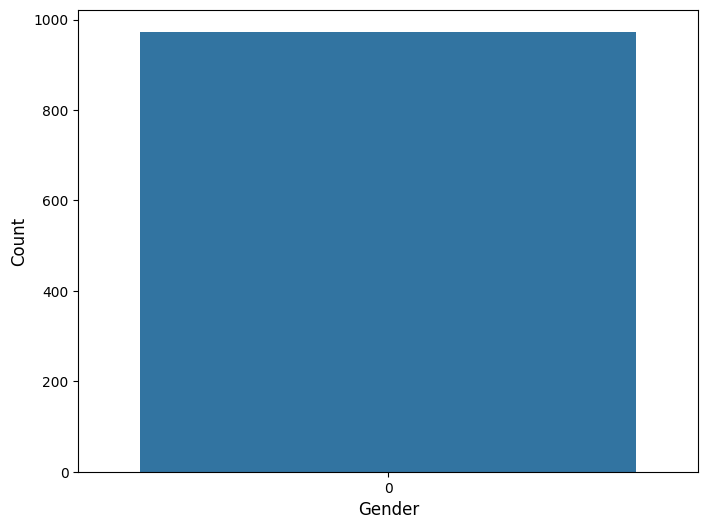

In [36]:
plt.figure(figsize=(8, 6))
sns.countplot(df['Gender'])
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)

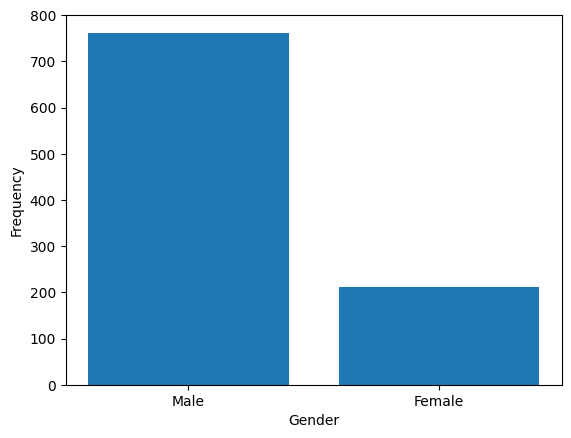

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the histogram for the Gender Protected Class
plt.hist(df['Gender'], bins=[0.5, 1.5, 2.5], rwidth=0.8)

# set the lables for the x and y axes
plt.xlabel('Gender')
plt.ylabel('Frequency')

# set x ticks
plt.xticks([1, 2], ['Male', 'Female'])

# Show the histogram
plt.show()


Text(0, 0.5, 'Count')

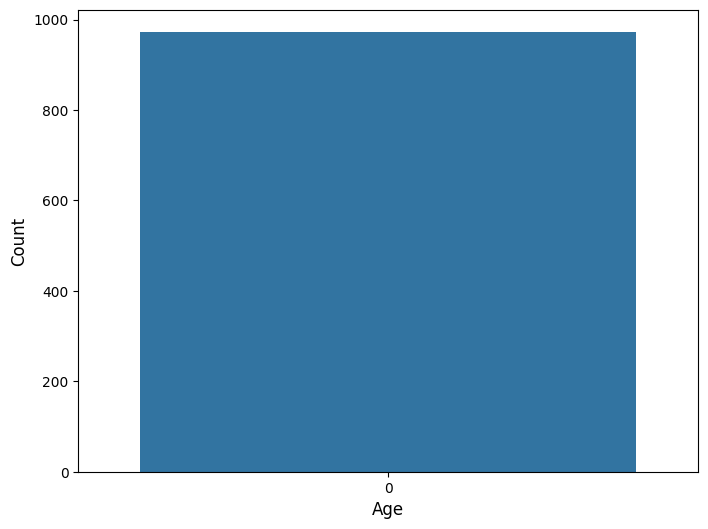

In [38]:
plt.figure(figsize=(8, 6))
sns.countplot(df['Age'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)

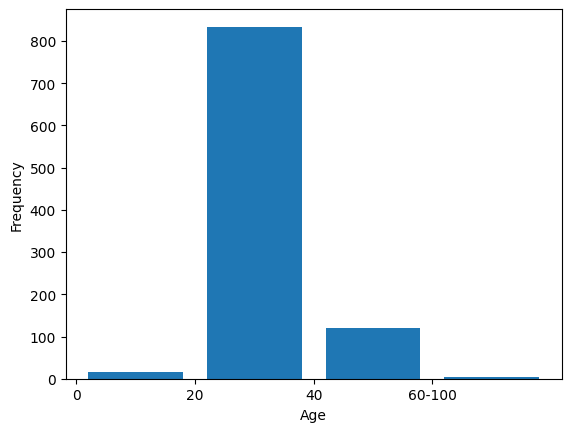

In [39]:
import matplotlib.pyplot as plt

# create histogram for Age column
plt.hist(df['Age'], bins=[1, 2, 3, 4, 5], rwidth=0.8)
plt.xticks([1, 2, 3, 4], ['0', '20', '40', '60-100'])
plt.xlabel('Age')
plt.ylabel('Frequency')

# add legend
#plt.legend(['0-20', '20-40', '40-60', '60-100'])

# show plot
plt.show()


In [40]:
df['treatment'].value_counts()

1    614
0    359
Name: treatment, dtype: int64

In [41]:
df.groupby(['Age','treatment'])['treatment'].count()

Age  treatment
1    0              8
     1              8
2    0            314
     1            520
3    0             36
     1             84
4    0              1
     1              2
Name: treatment, dtype: int64

In [42]:
df.groupby(['Gender','treatment'])['treatment'].count()

Gender  treatment
1       0            317
        1            445
2       0             42
        1            169
Name: treatment, dtype: int64

In [43]:
df.groupby(['Age','obs_consequence'])['obs_consequence'].count()

Age  obs_consequence
1    1                    0
     2                   16
2    1                  131
     2                  703
3    1                   26
     2                   94
4    1                    2
     2                    1
Name: obs_consequence, dtype: int64

In [44]:
df.groupby(['Gender','obs_consequence'])['obs_consequence'].count()

Gender  obs_consequence
1       1                  113
        2                  649
2       1                   46
        2                  165
Name: obs_consequence, dtype: int64

In [45]:
# Priviliged - > Age 1,2
# Unpriviliged - > Age 3,4

df['Gender'].value_counts()

1    762
2    211
Name: Gender, dtype: int64

In [46]:
import seaborn as sns
x_vars = ['treatment', 'work_interfere',
       'obs_consequence']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = list(df.select_dtypes(include=numerics).columns)

In [47]:
def plot_feature(field): 
  # fig, ax =plt.subplots(1,3, figsize=(18, 6) )
  plt.figure(figsize=(18,8))
  sns.countplot(data=df, x=field, hue="Gender") ;
  plt.xticks(rotation=45)
  plt.figure(figsize=(18,8))
  sns.countplot(data=df, x=field, hue="Age" ) ;
  plt.xticks(rotation=45)
  

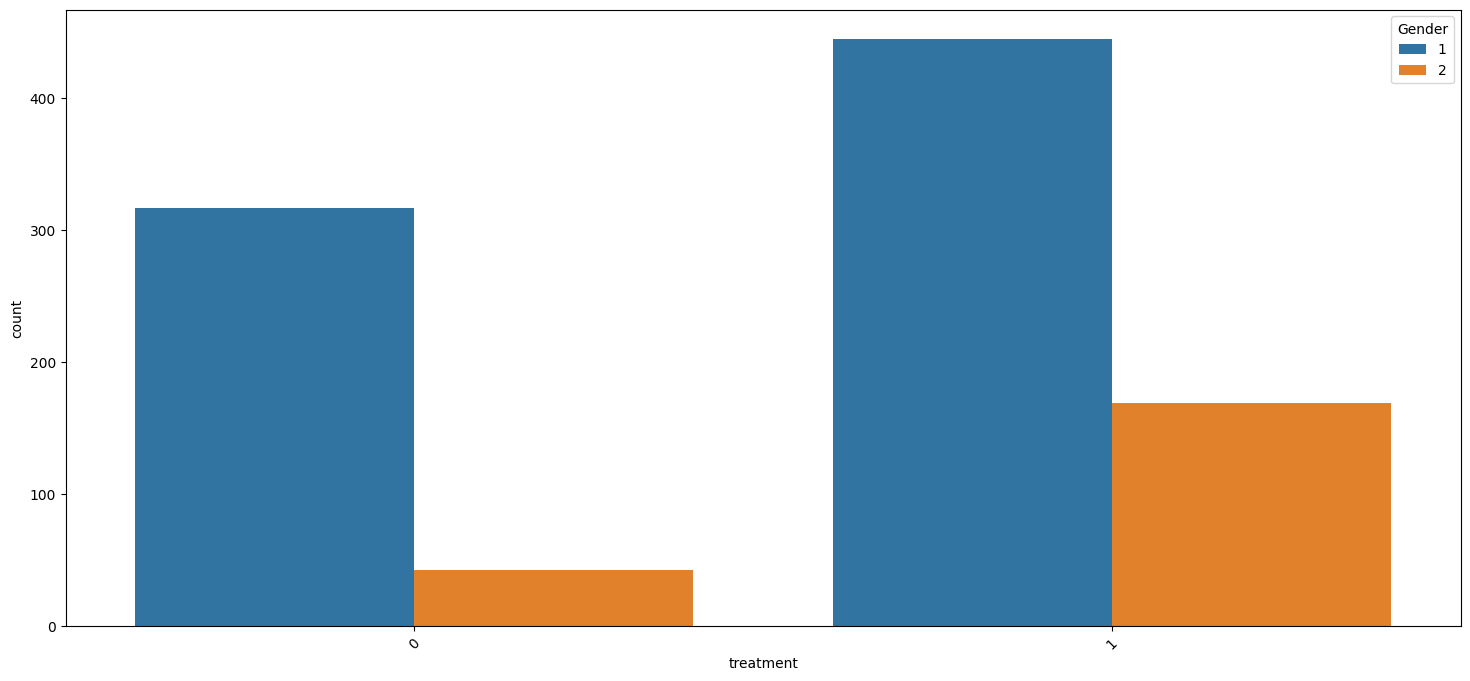

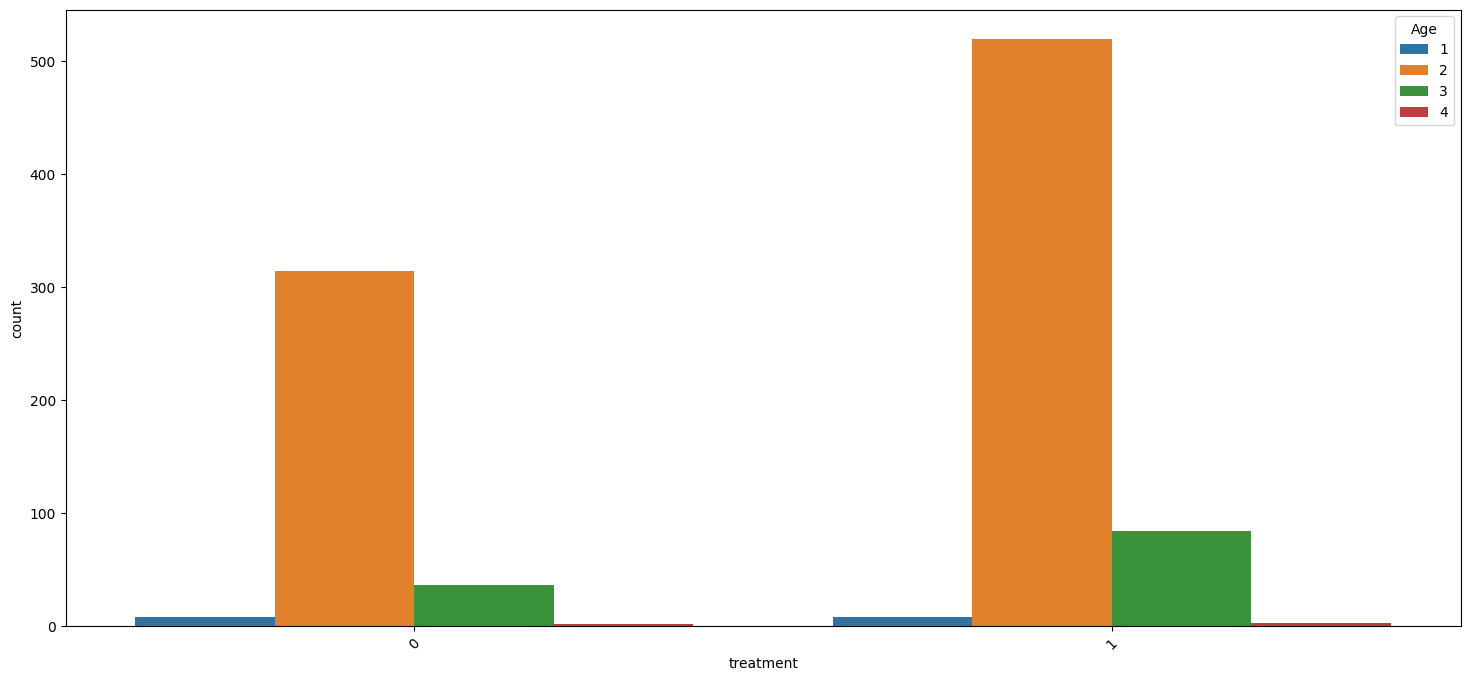

In [48]:
plot_feature("treatment")  

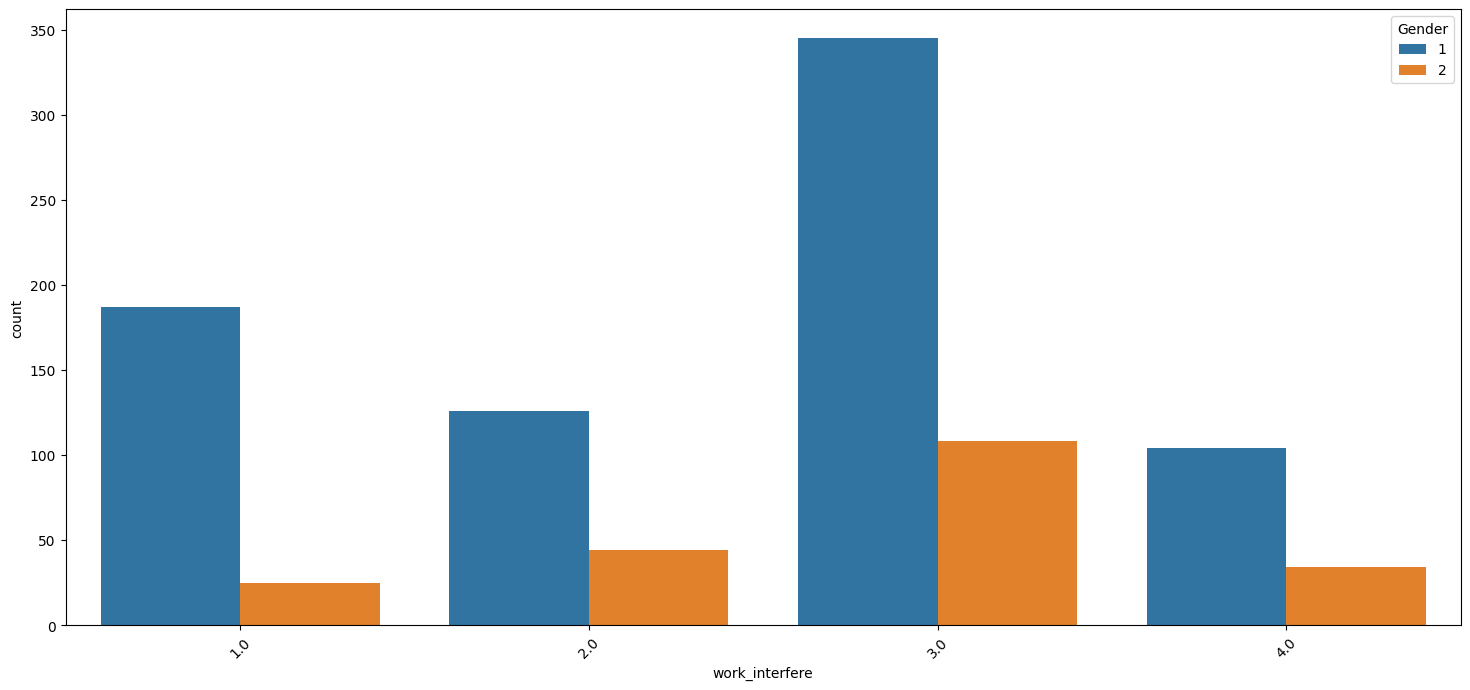

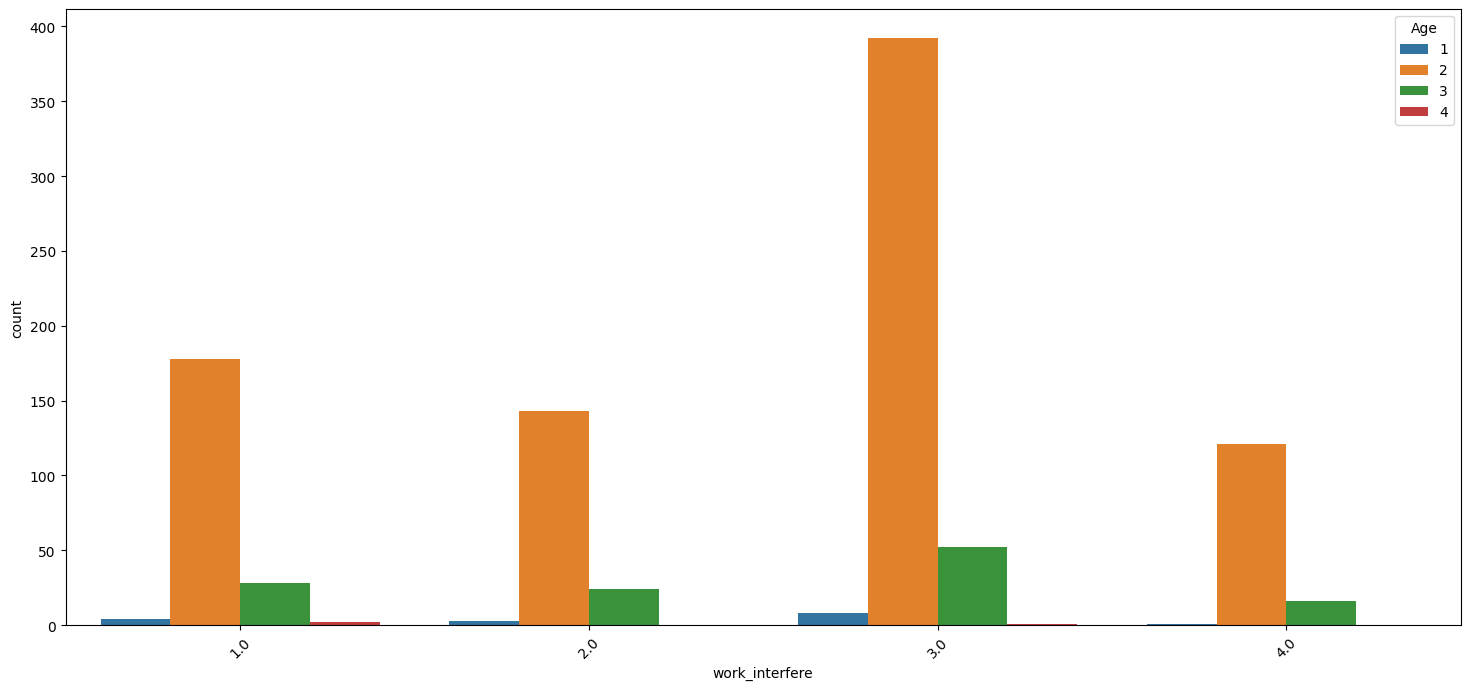

In [49]:
plot_feature("work_interfere")  

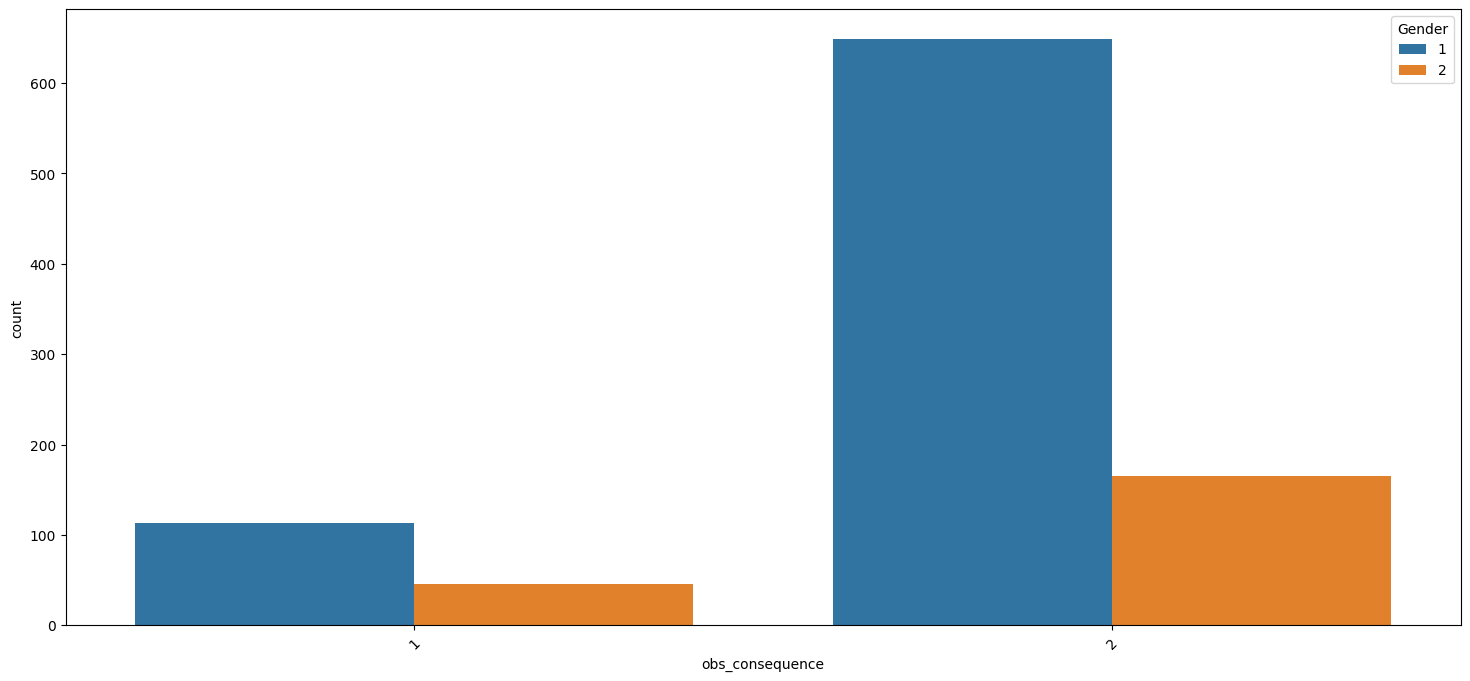

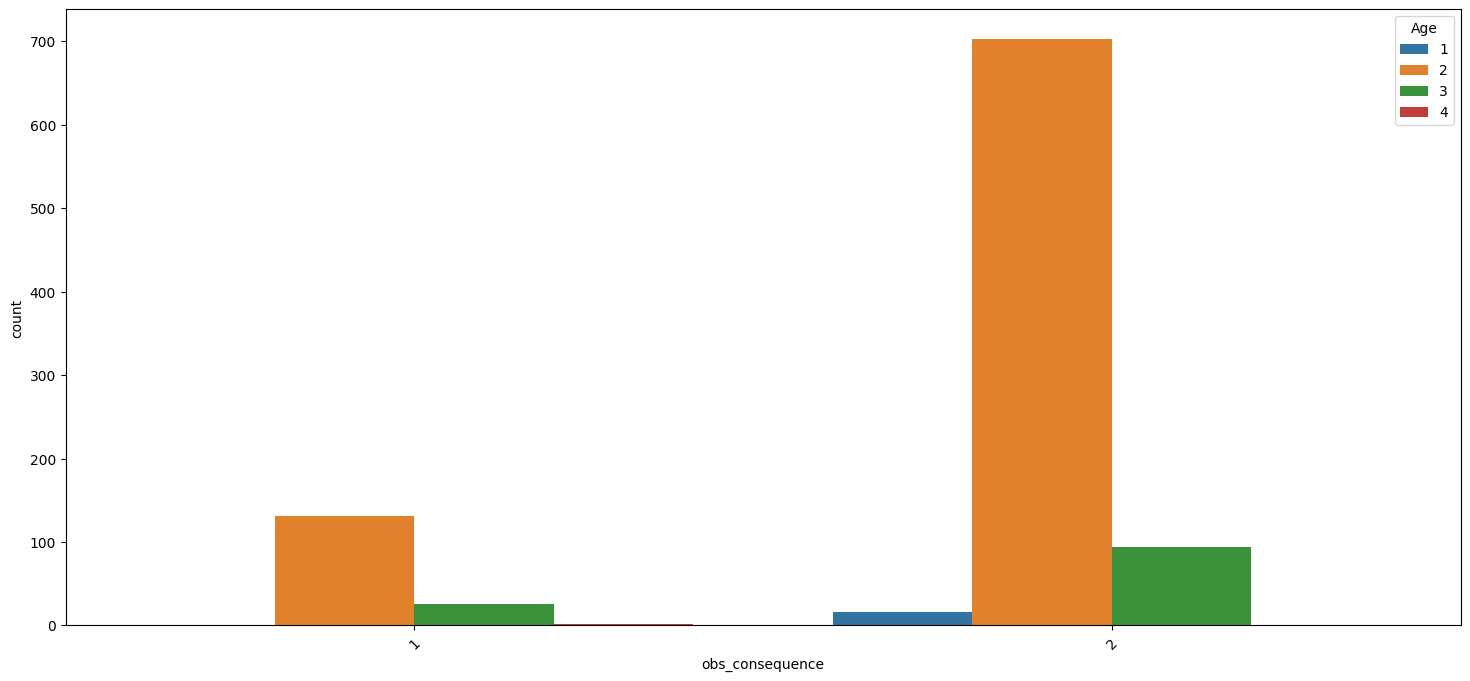

In [50]:
plot_feature("obs_consequence")  

##Step 3: For the next set of questions, you are allowed to code up your own mathematical formulations, modify open-source code that wasn’t developed for this course, or modify code found from the AI Fairness 360 Open Source Toolkit (https://aif360.mybluemix.net/) or the What-If Tool (https://pair-code.github.io/what-if-tool/) to work with your dataset. Note: Others have found it easier to create their own formulas based on the fairness definitions found in the class lectures or on the toolkit website rather than modifying the code in the AI Fairness or What-If Tool packages.
1) Based on your dataset, identify the privileged/unprivileged groups associated with each of your protected class variables
2) For each protected class variable, select two fairness metrics and compute the fairness metrics associated with your privileged/unprivileged groups as a function of each of your two dependent variables. You may choose any reasonable threshold in order to generate a baseline for comparison using the fairness metrics.
3) Select a pre-processing bias mitigation algorithm to transform the original dataset (e.g. Reweighting, Disparate Impact Remover, etc.) as a function of one of your dependent variables
4) Use the two fairness metrics identified in 3.2 and compute the fairness metrics on the transformed dataset

##BEFORE BIAS MITIGATION

In [51]:
df = df.drop(columns=['Timestamp', 'Country', 'state', 'comments'])

In [52]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH AGE AS A FUNCTION OF TREATMENT
#Convert 'Age' column to numeric datatype and replace any non-numeric values with NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

#Convert 'treatment' column to numeric datatype and replace any non-numeric values with NaN
df['treatment'] = pd.to_numeric(df['treatment'], errors='coerce')

# Drop NaN values in the dataframe
df.dropna(inplace=True)

# Create a binary classification dataset using the privileged and unprivileged classes of the Age protected attribute and the privileged class of the Treatment dependent variable
binarydataset_age = StandardDataset(df, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Age'],
                                 privileged_classes=[[1, 2]])

# Create a fairness metric object for fairness metric calculation using the privileged and unprivileged groups in the Age protected class
metric = BinaryLabelDatasetMetric(binarydataset_age, unprivileged_groups=[{'Age': 3}, {'Age': 4}], privileged_groups=[{'Age': 1}, {'Age': 2}])

# Compute and display the Disparate Impact fairness metric
disparate_impact = metric.disparate_impact()
print(f'Disparate Impact: {disparate_impact}')

# Compute and display the Consistency fairness metric
consistency_metric = metric.consistency()
print(f'Consistency: {consistency_metric}')

Disparate Impact: 1.1255851194875586
Consistency: [0.7294964]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


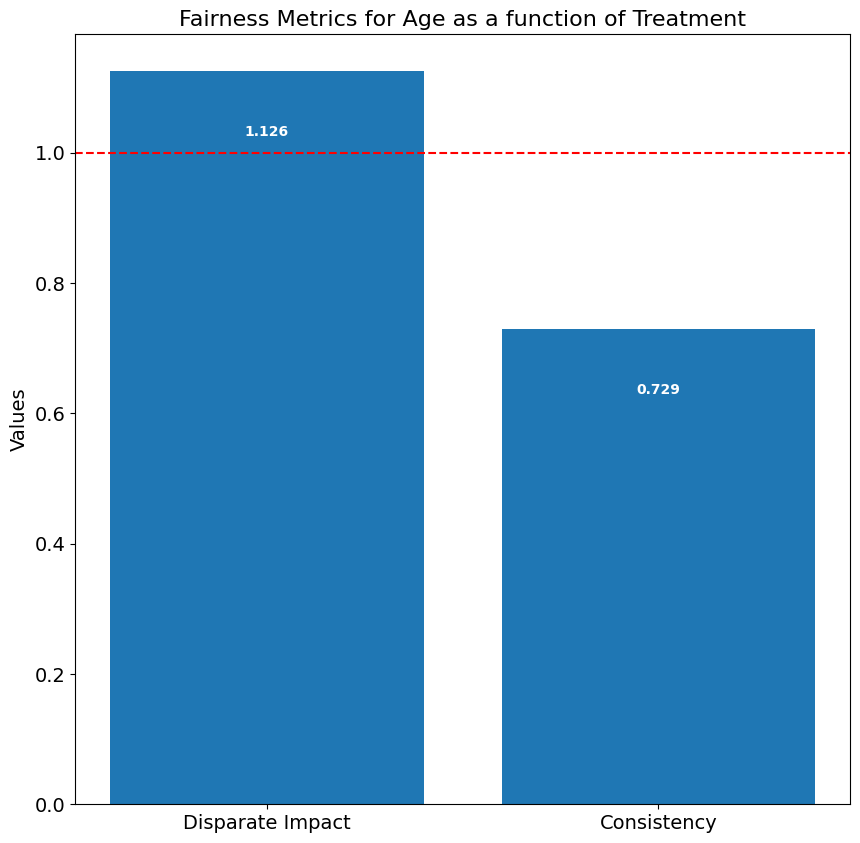

In [53]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH AGE AS A FUNCTION OF TREATMENT
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Age as a function of Treatment
fairness_metrics = ['Disparate Impact', 'Consistency']
values = [disparate_impact, consistency_metric]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Age as a function of Treatment', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [54]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH GENDER AS A FUNCTION OF TREATMENT
# Create a binary classification dataset using the privileged and unprivileged classes of the Gender protected attribute and the privileged class of the Treatment dependent variable
binarydataset_gender = StandardDataset(df, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

# Create a fairness metric object for fairness metric calculation using the privileged and unprivileged groups in the Gender protected class
metric1 = BinaryLabelDatasetMetric(binarydataset_gender, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

# Compute and display the Disparate Impact fairness metric
disparate_impact1 = metric1.disparate_impact()
print(f'Disparate Impact: {disparate_impact1}')

# Compute and display the Consistency fairness metric
consistency_metric1 = metric1.consistency()
print(f'Consistency: {consistency_metric1}')

Disparate Impact: 1.3715107300708238
Consistency: [0.7294964]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


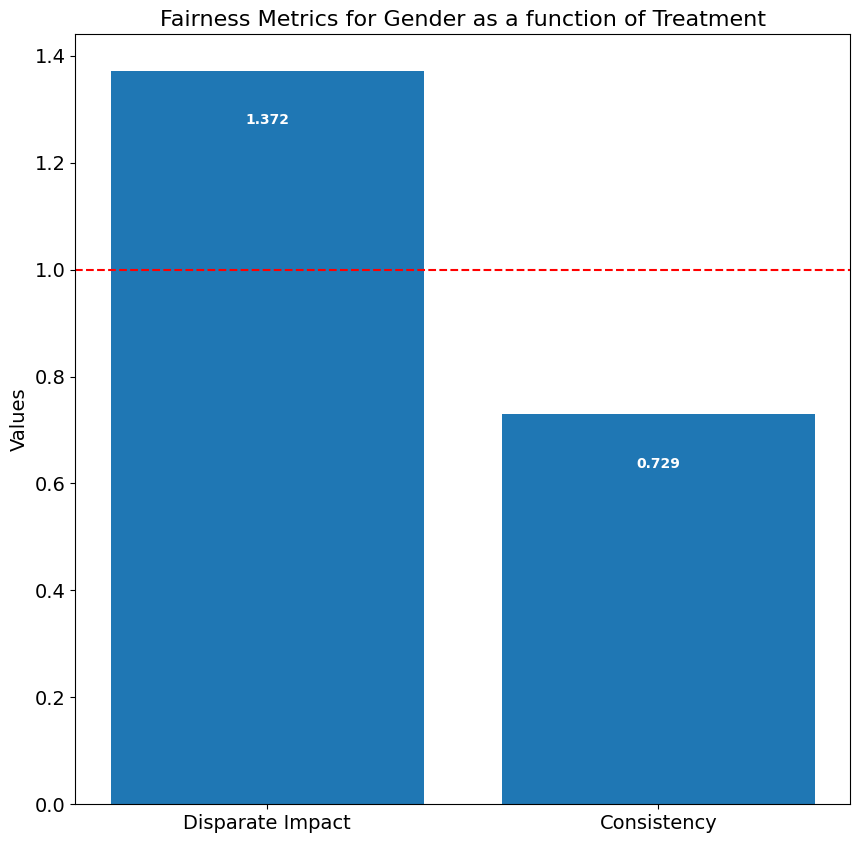

In [55]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH GENDER AS A FUNCTION OF TREATMENT
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Gender as a function of Treatment
fairness_metrics = ['Disparate Impact', 'Consistency']
values1 = [disparate_impact1, consistency_metric1]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values1)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values1):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Gender as a function of Treatment', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [56]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH AGE AS A FUNCTION OF OBS_CONSEQUENCE
#Convert 'Age' column to numeric datatype and replace any non-numeric values with NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

#Convert 'obs_consequence' column to numeric datatype and replace any non-numeric values with NaN
df['obs_consequence'] = pd.to_numeric(df['obs_consequence'], errors='coerce')

# Drop NaN values in the dataframe
df.dropna(inplace=True)

# Create a binary classification dataset using the privileged and unprivileged classes of the Age protected attribute and the privileged class of the obs_consequence dependent variable
binarydataset_age2 = StandardDataset(df, label_name='obs_consequence',
                                 favorable_classes=[2],
                                 protected_attribute_names=['Age'],
                                 privileged_classes=[[1, 2]])

# Create a fairness metric object for fairness metric calculation using the privileged and unprivileged groups in the Age protected class
metric2 = BinaryLabelDatasetMetric(binarydataset_age2, unprivileged_groups=[{'Age': 3}, {'Age': 4}], privileged_groups=[{'Age': 1}, {'Age': 2}])

# Compute and display the Disparate Impact fairness metric
disparate_impact2 = metric2.disparate_impact()
print(f'Disparate Impact: {disparate_impact2}')

# Compute and display the Consistency fairness metric
consistency_metric2 = metric2.consistency()
print(f'Consistency: {consistency_metric2}')

Disparate Impact: 0.9130793672331716
Consistency: [0.81274409]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


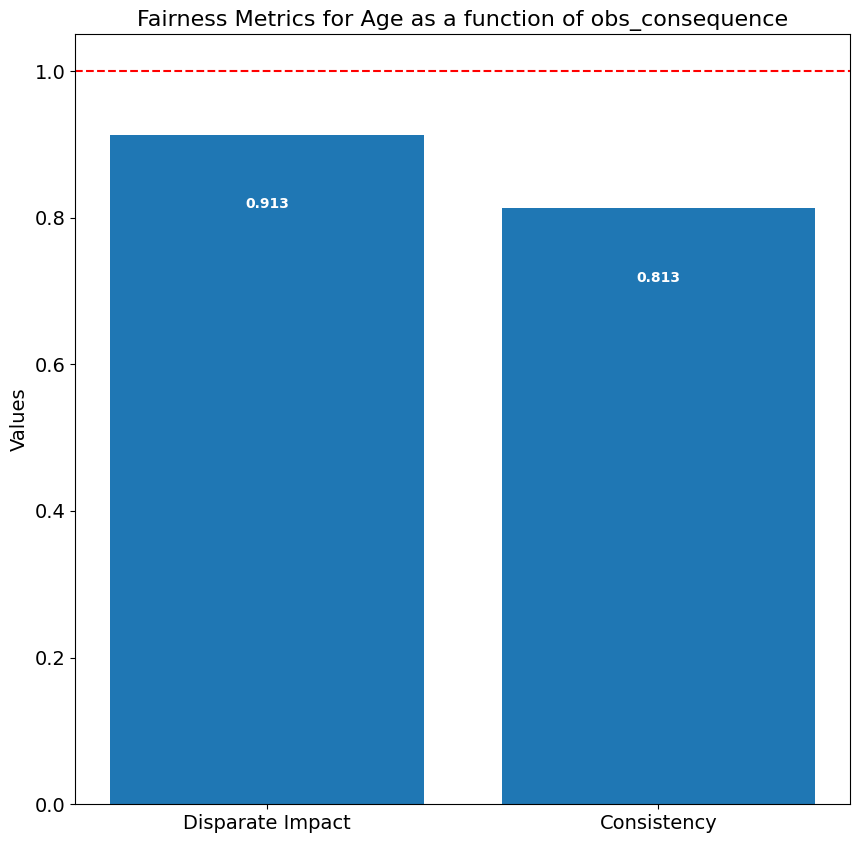

In [57]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH AGE AS A FUNCTION OF OBS_CONSEQUENCE
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Age as a function of obs_consequence
fairness_metrics2 = ['Disparate Impact', 'Consistency']
values2 = [disparate_impact2, consistency_metric2]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics2, values2)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values2):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Age as a function of obs_consequence', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [58]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH GENDER AS A FUNCTION OF OBS_CONSEQUENCE
# Create a binary classification dataset using the privileged and unprivileged classes of the Gender protected attribute and the privileged class of the obs_consequence dependent variable
binarydataset_gender3 = StandardDataset(df, label_name='obs_consequence',
                                 favorable_classes=[2],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

# Create a fairness metric object for fairness metric calculation using the privileged and unprivileged groups in the Gender protected class
metric3 = BinaryLabelDatasetMetric(binarydataset_gender3, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

# Compute and display the Disparate Impact fairness metric
disparate_impact3 = metric3.disparate_impact()
print(f'Disparate Impact: {disparate_impact3}')

# Compute and display the Consistency fairness metric
consistency_metric3 = metric3.consistency()
print(f'Consistency: {consistency_metric3}')

Disparate Impact: 0.9181460358261708
Consistency: [0.81274409]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


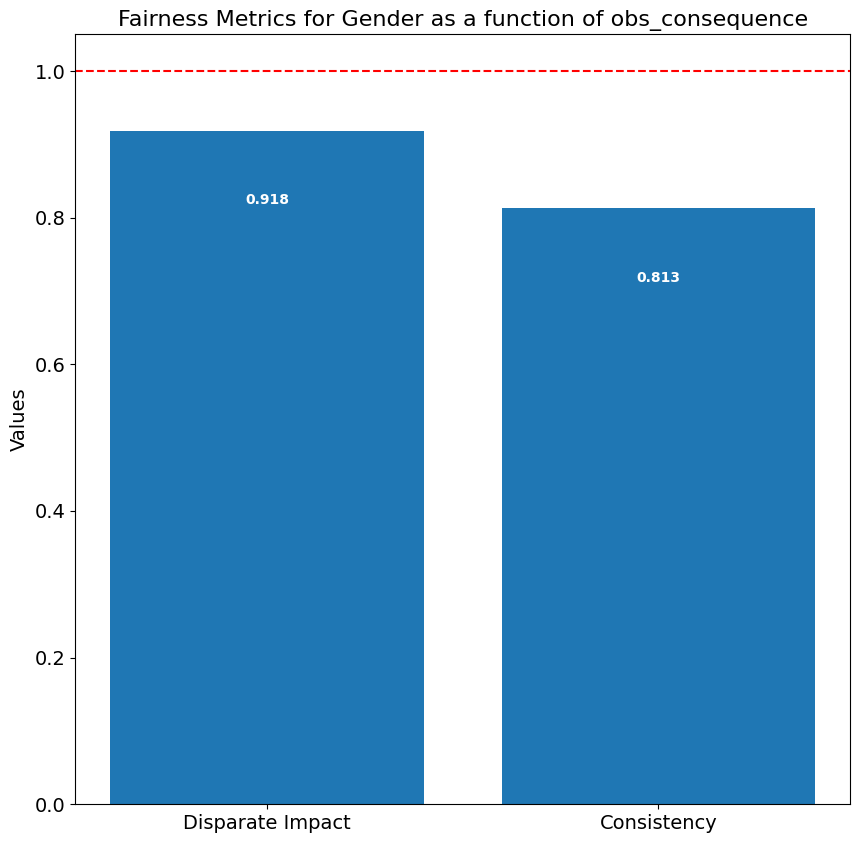

In [59]:
#Step 3.2 - FAIRNESS METRIC ASSOCIATED WITH GENDER AS A FUNCTION OF OBS_CONSEQUENCE
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Gender as a function of obs_consequence
fairness_metrics3 = ['Disparate Impact', 'Consistency']
values3 = [disparate_impact3, consistency_metric3]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics3, values3)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values3):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Gender as a function of obs_consequence', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

##AFTER BIAS MITIGATION

In [60]:
#Step 3.3 - BIAS MITIGATION RELATING TO GENDER AS A FUNCTION OF TREATMENT
# Create a binary classification dataset using the privileged and unprivileged classes of the Gender protected attribute and the privileged class of the Treatment dependent variable
binarydataset_gender1 = StandardDataset(df, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

# Use the Reweigh algorithm to mitigate bias relating to Gender and transform the dataset
bias_mitigated = Reweighing(unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])
# The new transformed dataset is stored in the dataframe 'new_df'
new_df = bias_mitigated.fit_transform(binarydataset_gender1)

# Create a fairness metric object for fairness metric calculation using the new transformed dataframe, the privileged and unprivileged groups in the Gender protected class
binarydataset = BinaryLabelDatasetMetric(new_df, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

# Compute and display the Disparate Impact fairness metric from the new transformed dataset
disparate_impact13 = binarydataset.disparate_impact()
print(f'Disparate Impact (transformed dataset): {disparate_impact13}')

# Compute and display the Consistency fairness metric from the new transformed dataset
consistency13 = binarydataset.consistency()
print(f'Consistency (transformed dataset): {consistency13}')

Disparate Impact (transformed dataset): 0.9999999999999998
Consistency (transformed dataset): [0.7294964]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


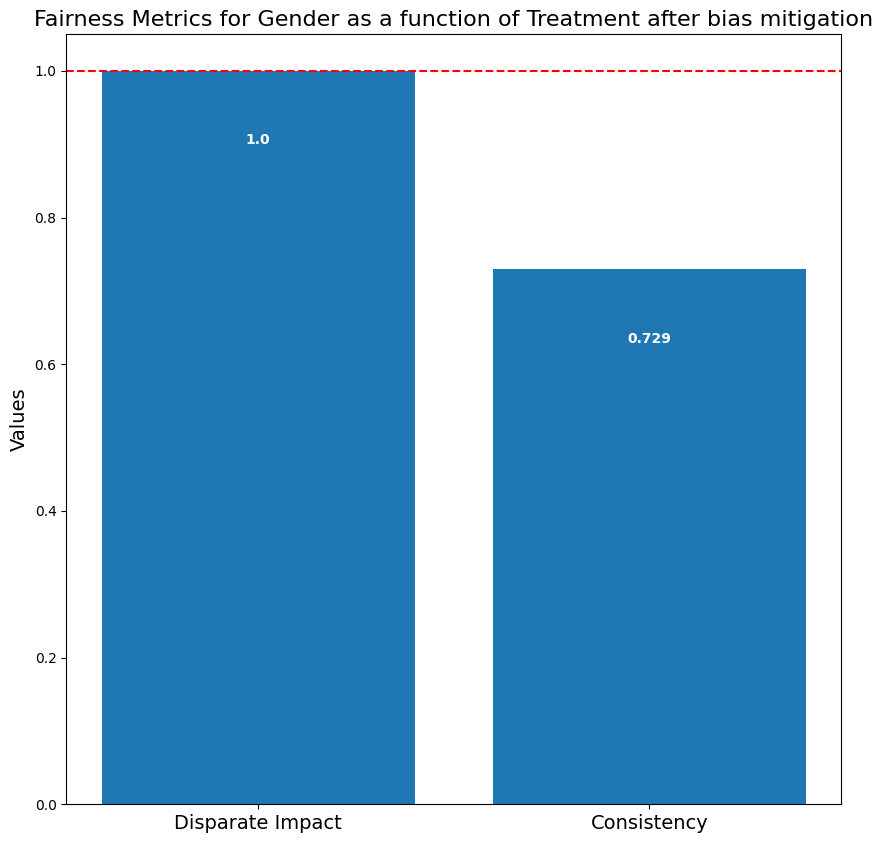

In [61]:
#Step 3.3 - BIAS MITIGATION RELATING TO GENDER AS A FUNCTION OF TREATMENT
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Gender as a function of Treatment in the transformed dataset
fairness_metrics = ['Disparate Impact', 'Consistency']
values13 = [disparate_impact13, consistency13]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values13)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values13):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Gender as a function of Treatment after bias mitigation', fontsize=16)
plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [62]:
#Step 3.3 - BIAS MITIGATION RELATING TO AGE AS A FUNCTION OF TREATMENT
# Create a binary classification dataset using the privileged and unprivileged classes of the Age protected attribute and the privileged class of the Treatment dependent variable
binarydataset_gender12 = StandardDataset(df, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Age'],
                                 privileged_classes=[[1, 2]])


# Use the Reweigh algorithm to mitigate bias relating to Age and transform the dataset
bias_mitigated1 = Reweighing(unprivileged_groups=[{'Age': 3}, {'Age': 4}], privileged_groups=[{'Age': 1}, {'Age': 2}])
# The new transformed dataset is stored in the dataframe 'new_df2'
new_df2 = bias_mitigated1.fit_transform(binarydataset_gender12)

# Create a binary dataset for fairness metric calculation using the new transformed dataframe, the privileged and unprivileged groups in the Age protected class
binarydataset1 = BinaryLabelDatasetMetric(new_df2, unprivileged_groups=[{'Age': 3}, {'Age': 4}], privileged_groups=[{'Age': 1}, {'Age': 2}])

# Compute and display the Disparate Impact fairness metric from the new transformed dataset
disparate_impact12 = binarydataset1.disparate_impact()
print(f'Disparate Impact (transformed dataset): {disparate_impact12}')

# Compute and display the Consistency fairness metric from the new transformed dataset
consistency12 = binarydataset1.consistency()
print(f'Consistency (transformed dataset): {consistency12}')

Disparate Impact (transformed dataset): 0.9999999999999998
Consistency (transformed dataset): [0.7294964]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


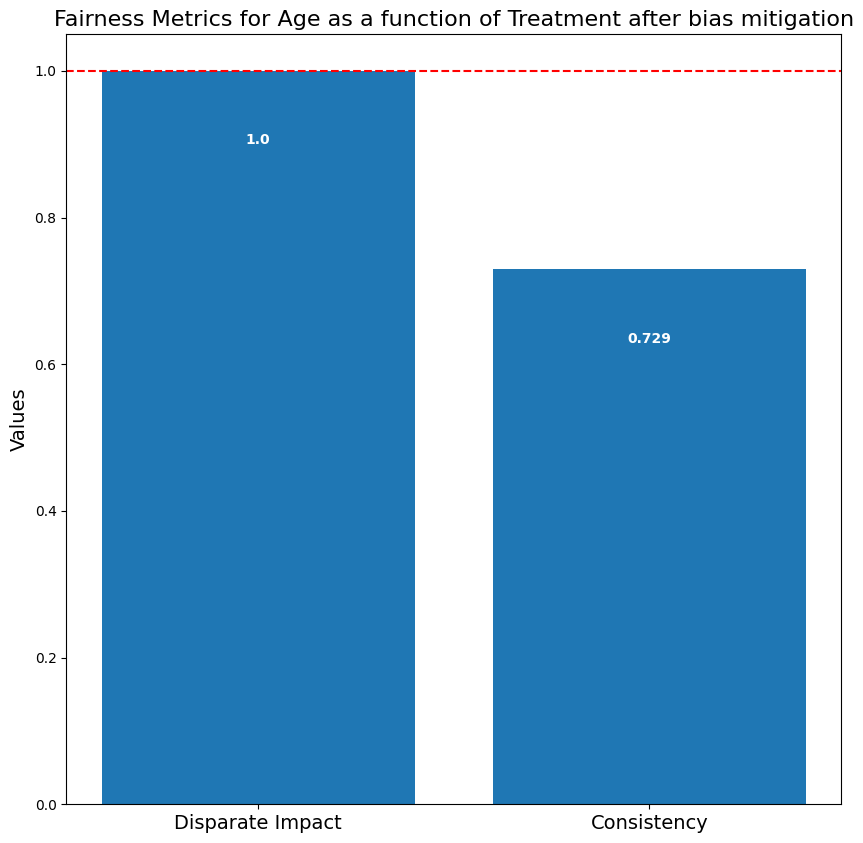

In [63]:
#Step 3.3 - BIAS MITIGATION RELATING TO AGE AS A FUNCTION OF TREATMENT
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Age as a function of Treatment in the transformed dataset
fairness_metrics = ['Disparate Impact', 'Consistency']
values12 = [disparate_impact12, consistency12]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values12)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values12):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Age as a function of Treatment after bias mitigation', fontsize=16)
plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [64]:
#Step 3.3 - BIAS MITIGATION RELATING TO GENDER AS A FUNCTION OF OBS_CONSEQUENCE
# Create a binary classification dataset using the privileged and unprivileged classes of the Gender protected attribute and the privileged class of the obs_consequence dependent variable
binarydataset_gender2 = StandardDataset(df, label_name='obs_consequence',
                                 favorable_classes=[2],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

# Use the Reweigh algorithm to mitigate bias relating to Gender and transform the dataset
bias_mitigated2 = Reweighing(unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])
# The new transformed dataset is stored in the dataframe 'new_df3'
new_df3 = bias_mitigated2.fit_transform(binarydataset_gender2)

# Create a fairness metric object for fairness metric calculation using the new transformed dataframe, the privileged and unprivileged groups in the Gender protected class
binarydataset2 = BinaryLabelDatasetMetric(new_df3, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

# Compute and display the Disparate Impact fairness metric from the new transformed dataset
disparate_impact4 = binarydataset2.disparate_impact()
print(f'Disparate Impact (transformed dataset): {disparate_impact4}')

# Compute and display the Consistency fairness metric from the new transformed dataset
consistency4 = binarydataset2.consistency()
print(f'Consistency (transformed dataset): {consistency4}')

Disparate Impact (transformed dataset): 0.9999999999999998
Consistency (transformed dataset): [0.81274409]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


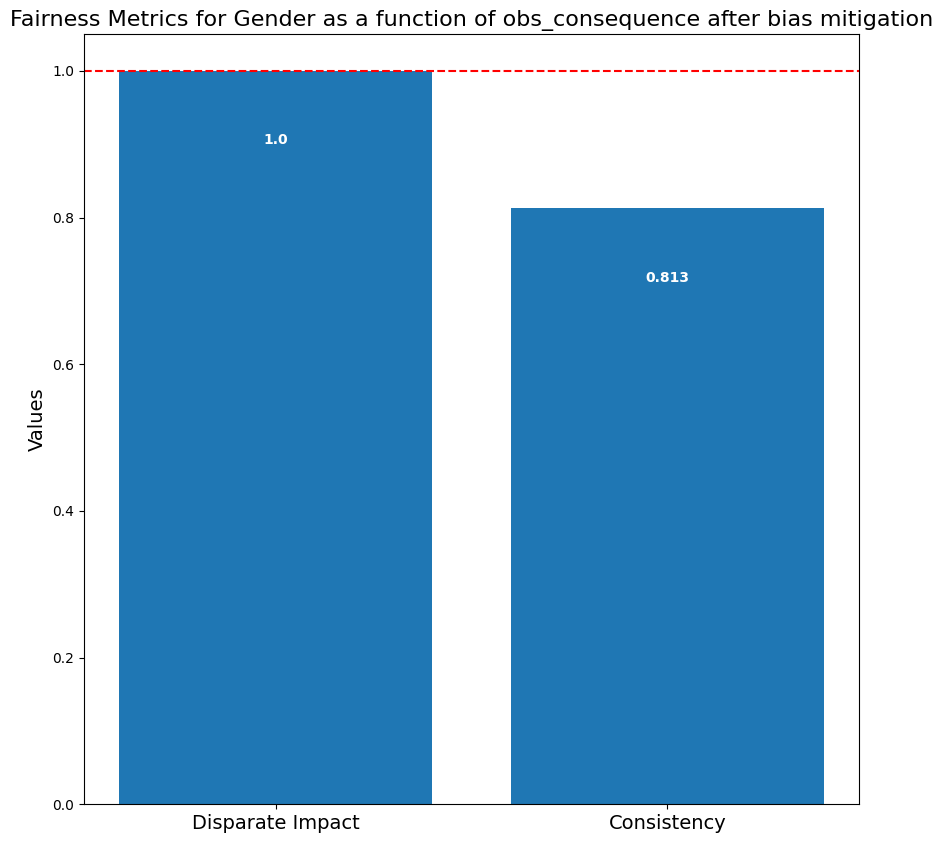

In [65]:
#Step 3.3 - BIAS MITIGATION RELATING TO GENDER AS A FUNCTION OF OBS_CONSEQUENCE
# Plot the histogram of the Disparate Impact and Consistency fairness metrics for Gender as a function of obs_consequence in the transformed dataset
fairness_metrics4 = ['Disparate Impact', 'Consistency']
values4 = [disparate_impact4, consistency4]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics4, values4)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values4):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')



plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics for Gender as a function of obs_consequence after bias mitigation', fontsize=16)
plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

##Step 4: There are two options for Step 4 – Choose one to complete for the final project. Specify which option you are choosing in your final report.
Option A: For the next set of questions, you are allowed to code up your own algorithm, modify open-source code that wasn’t developed for this course, or modify code found from the AI Fairness 360 Open Source Toolkit to work with your dataset (https://github.com/IBM/AIF360/tree/master/examples). For example, code for training a classifier based on a credit scoring example can be found here: https://github.com/IBM/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb.
Note: Others have found it easier to create their own algorithm rather than modifying the code in the AI Fairness package.
1) Randomly split your original dataset into training and testing datasets
2) Randomly split your transformed dataset into training and testing datasets (from Step 3.3)
3) Train a classifier using the original training dataset from Step 4.1; select one of your dependent variables as the output label to train your classifier.
4) Train a classifier using the transformed training dataset from Step 4.2; select one of your dependent variables as the output label to train your classifier.
5) Select the privileged/unprivileged groups associated with one of your protected class variables (from Step 3.1); Use the two fairness metrics identified in Step 3.2 and and compute the fairness metrics for the classifier output associated with the original testing dataset and the transformed testing dataset
6) For each fairness metric, in table format, indicate if there were any differences in the outcomes for the privileged versus unprivileged group. Was there a positive change, negative change, or no change on that fairness metric after transforming the dataset (from Step 3.4)? Was there a positive change, negative change, or no change on that fairness metric after training the classifier - with respect to the original testing dataset and the transformed testing dataset? [Note: Use your subjective opinion]

Option B: For the next set of questions, you are to design your own bias mitigation algorithm
1) Design your own bias mitigation algorithm (must be different than ones already represented in the aif360.algorithms.preprocessing class) to transform your original dataset [Note: Provide sufficient comments in your code so that the algorithm/math can be deciphered]
2) Randomly split your original dataset into training and testing datasets
3) Apply your bias mitigation algorithm to your original testing dataset in order to produce a transformed testing dataset; select one of your protected class variables and one of your dependent variables as the output label
4) Randomly split your transformed dataset into training and testing datasets
5) Select the privileged/unprivileged groups associated with your protected class variables; Use the two fairness metrics identified in Step 3.2 and compute the fairness metrics on the original testing dataset and the transformed testing dataset
6) For each fairness metric, in table format, discuss if there were any differences in the outcomes for the privileged versus unprivileged group. Was there a positive change, negative change, or no change on that fairness metric after transforming the dataset earlier in Step 3.4? Was there a positive change, negative change, or no change on that fairness metric after applying your bias mitigation algorithm - with respect to the original testing dataset and the transformed testing dataset? [Note: Use your subjective opinion]

###OPTION A

In [66]:
# Splitting data into train and test sets

train_df = df.sample(frac = 0.5, random_state=975)
test_df = df.drop(train_df.index)
X_train = train_df.drop('treatment', axis=1)
y_train = train_df['treatment']
X_test = test_df.drop('treatment', axis=1)
y_test = test_df['treatment']

In [67]:
# Some columns gave errors with model so using onehotencoder on columns

cat_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company', 
            'benefits', 'care_options', 'wellness_program', 'seek_help', 
            'anonymity', 'leave', 'mental_health_consequence', 
            'phys_health_consequence', 'coworkers', 'supervisor', 
            'mental_vs_physical']


ct = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), cat_cols)],
    remainder='passthrough' 
    
    
)


# Encoded features
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

# Model
xgb_cl = xgb.XGBClassifier(seed=400)
xgb_cl.fit(X_train_enc, y_train)

# Predictions
preds = xgb_cl.predict(X_test_enc)

# Accuracy Score
accuracy_score(y_test, preds)

0.728952772073922

In [68]:
# Adding our preds as treatment column to X_test so that we can continue with bias checks
check_bias = pd.concat([X_test.reset_index(drop=True), pd.Series(preds, name='treatment')], axis=1)

In [69]:
# Converting the check bias df into standard dataset
binarydataset_gender = StandardDataset(check_bias, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

metric = BinaryLabelDatasetMetric(binarydataset_gender, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

#Metrics
disparate_impact = metric.disparate_impact()
print(f'Disparate Impact: {disparate_impact}')
consistency_metric = metric.consistency()
print(f'Consistency: {consistency_metric}')

Disparate Impact: 1.3682454427083333
Consistency: [0.8073922]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


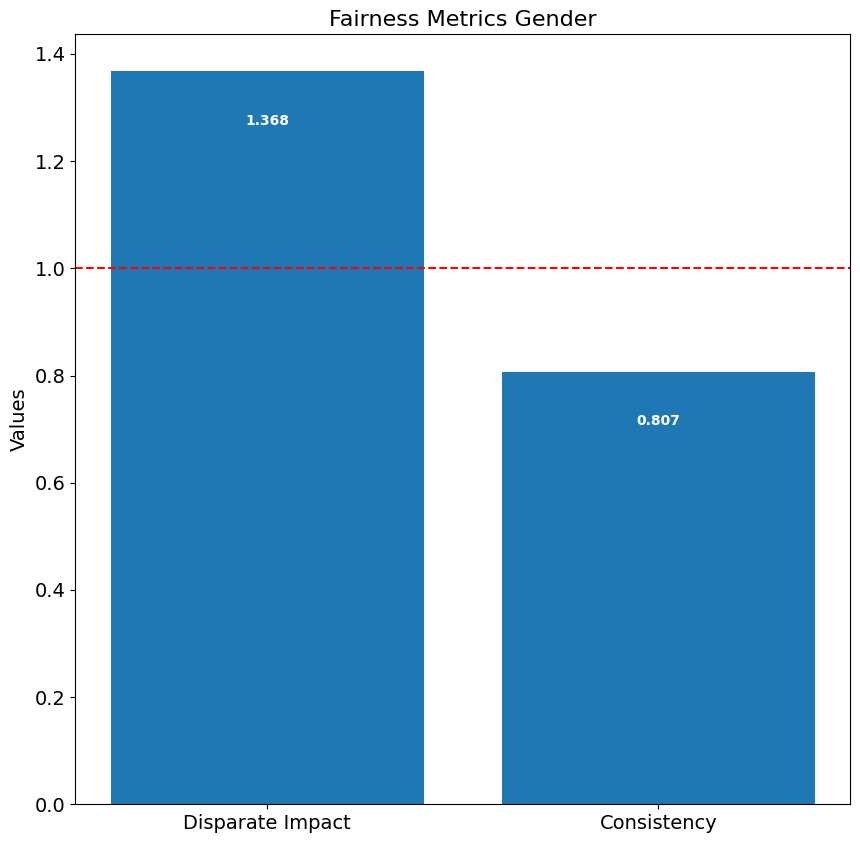

In [70]:
fairness_metrics = ['Disparate Impact', 'Consistency']
values = [disparate_impact, consistency_metric]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')


plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics Gender', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()

In [71]:
# Creating a standard dataset from the df for the second part of the step
binarydataset_gender = StandardDataset(df, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])


# Reweighing df
bias_mitigated = Reweighing(unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])
new_df = bias_mitigated.fit_transform(binarydataset_gender)

In [72]:
# Splitting transformed df
train_data, test_data = new_df.split([0.5], shuffle=True, seed=464)

# Converting the transformed df's into pandas df
train_df = train_data.convert_to_dataframe()[0]
test_df = test_data.convert_to_dataframe()[0]

In [73]:
# Splitting data again

X_train = train_df.drop('treatment', axis=1)
y_train = train_df['treatment']
X_test = test_df.drop('treatment', axis=1)
y_test = test_df['treatment']

In [74]:
# One hot encoding again
ct = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), cat_cols)],
    remainder='passthrough' 
    
    
)


X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

# Train the model with weights from the transformed df
xgb_cl = xgb.XGBClassifier(seed=400)
xgb_cl.fit(X_train_enc, y_train, sample_weight=train_data.instance_weights)

preds = xgb_cl.predict(X_test_enc)

accuracy_score(y_test, preds)

0.7248459958932238

In [75]:
# Adding our preds as treatment column to X_test so that we can continue with bias checks

check_bias = pd.concat([X_test.reset_index(drop=True), pd.Series(preds, name='treatment')], axis=1)


In [76]:
# Converting the check bias df into standard dataset

binarydataset_gender = StandardDataset(check_bias, label_name='treatment',
                                 favorable_classes=[1],
                                 protected_attribute_names=['Gender'],
                                 privileged_classes=[[1]])

metric = BinaryLabelDatasetMetric(binarydataset_gender, unprivileged_groups=[{'Gender': 2}], privileged_groups=[{'Gender': 1}])

#Metrics
disparate_impact = metric.disparate_impact()
print(f'Disparate Impact: {disparate_impact}')
consistency_metric = metric.consistency()
print(f'Consistency: {consistency_metric}')

Disparate Impact: 1.3763598326359832
Consistency: [0.79014374]


/usr/local/lib/python3.9/dist-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


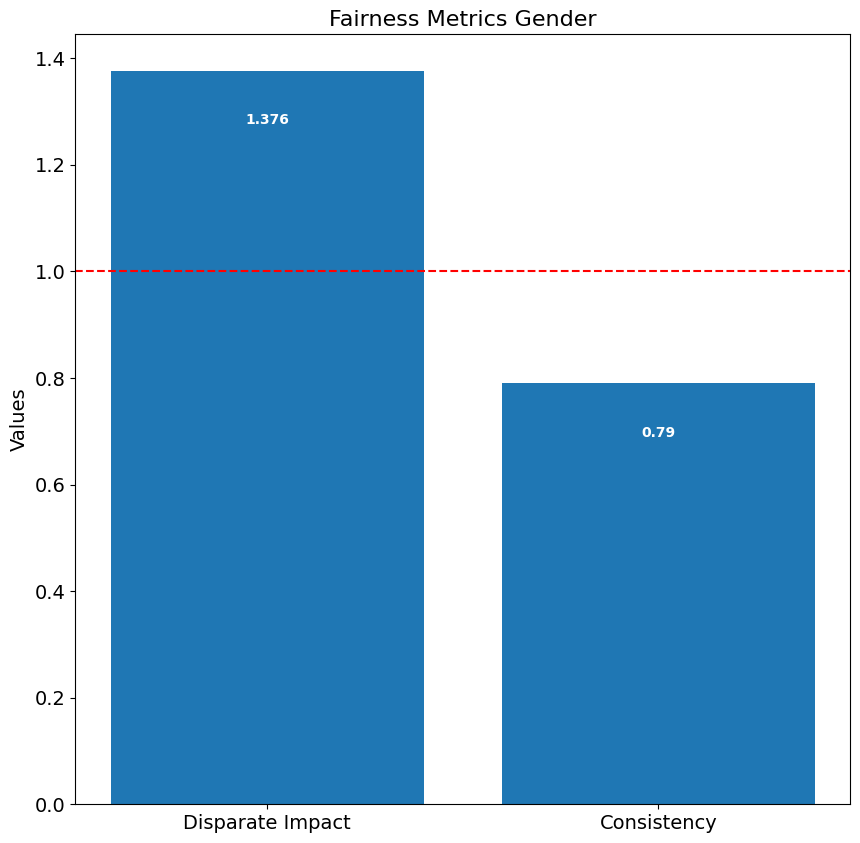

In [77]:
fairness_metrics = ['Disparate Impact', 'Consistency']
values = [disparate_impact, consistency_metric]
plt.figure(figsize=(10,10))
fair_thresholds = [1.0, 1.0]
plt.bar(fairness_metrics, values)
plt.axhline(y=1.0, color='r', linestyle='dashed', label='Fair Threshold')
for i, k in enumerate(values):
    plt.text(i, k-0.1, str(round(float(k), 3)), color='white', fontweight='bold', ha='center')

plt.ylabel('Values', fontsize=14)
plt.title('Fairness Metrics Gender', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(fontsize=14)


plt.show()